In [9]:
import numpy as np
from matplotlib import pyplot as plt
import torch
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi.utils.get_nn_models import posterior_nn
from sbi import utils
from sbi import analysis
from sbi.inference.base import infer
import corner

In [10]:
GNN_model = "20240220_EdgeNN"
prim_model = "20240220_EdgeNN_control"

GNN_preds = np.load(f"../outs/{GNN_model}/preds.npy")
prim_preds = np.load(f"../outs/{prim_model}/preds.npy")
GNN_labels = np.load(f"../outs/{GNN_model}/true.npy")
prim_labels = np.load(f"../outs/{prim_model}/true.npy")

In [11]:
labels = ["Om", "s8"]
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 7))
# add hspace and vspace
fig.subplots_adjust(wspace=0.3, hspace=0.2)
for i, ax in enumerate(axs.flatten()):
    ax.scatter(GNN_labels[:, i], GNN_preds[:, i], marker="x", alpha=0.5, s=1)
    ax.scatter(prim_labels[:, i], prim_preds[:, i], marker="x", alpha=0.5, s=1)
    ax.plot([np.min(prim_labels[:, i]), np.max(prim_labels[:, i])], \
                        [np.min(prim_labels[:, i]), np.max(prim_labels[:, i])], c="k")
    ax.set_xlim([np.min(prim_labels[:, i]), np.max(prim_labels[:, i])])
    ax.set_ylim([np.min(prim_labels[:, i]), np.max(prim_labels[:, i])])
    ax.set_xlabel("True")
    ax.set_ylabel("Predicted")
    ax.set_aspect("equal")
    ax.set_title(labels[i])
    ax.grid()
plt.show()
plt.close()

In [12]:
ind = np.random.randint(0, len(GNN_labels))
# ind = 1590
# ind = 0
x_0_gnn = GNN_preds[ind]
true = GNN_labels[ind]

# rn_ind = np.where(np.all(resnet_labels == true, axis=1))[0][0]
rn_ind = ind
x_0_prim = prim_preds[rn_ind]
print(ind, rn_ind)
print(x_0_gnn, x_0_prim)
print(true, prim_labels[rn_ind])

inds = np.delete(np.arange(0, len(GNN_labels)), ind)
GNN_labels, GNN_preds = GNN_labels[inds], GNN_preds[inds]
inds = np.delete(np.arange(0, len(prim_labels)), rn_ind)
prim_labels, prim_preds = prim_labels[inds], prim_preds[inds]

4679 4679
[0.31882614 0.71630102] [0.31415954 0.69411641]
[0.27206126 0.77236605] [0.27206126 0.77236605]


In [13]:
prior = utils.BoxUniform(low=np.min(prim_labels, axis=0), high=np.max(prim_labels, axis=0))
proposal = prior
inference = SNPE(prior=prior, density_estimator=utils.posterior_nn(model='maf',
                                                hidden_features=50,
                                                num_transforms=4))

theta, x = torch.FloatTensor(prim_labels), torch.FloatTensor(prim_preds)
density_estimator = inference.append_simulations(theta, x, proposal=proposal).train()
posterior_prim = inference.build_posterior(density_estimator)

proposal = prior
inference = SNPE(prior=prior, density_estimator=utils.posterior_nn(model='maf',
                                                hidden_features=50,
                                                num_transforms=4))

theta, x = torch.FloatTensor(GNN_labels), torch.FloatTensor(GNN_preds)
density_estimator = inference.append_simulations(theta, x, proposal=proposal).train()
posterior_GNN = inference.build_posterior(density_estimator)

 Neural network successfully converged after 58 epochs.

In [14]:
posterior_samples_prim = posterior_prim.set_default_x(x_0_prim).sample((10000,), x=x_0_prim)
posterior_samples_GNN = posterior_GNN.set_default_x(x_0_gnn).sample((10000,), x=x_0_gnn)

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

In [15]:
import getdist
from getdist import plots, MCSamples

gd_samples = [MCSamples(samples=posterior_samples_prim.numpy(), names=["Om", "s8"], labels=["Om", "s8"],
                label="Nom", ranges={"Om": [0.1, 0.5], "s8": [0.5, 1.5]}),
            MCSamples(samples=posterior_samples_GNN.numpy(), names=["Om", "s8"], labels=["Om", "s8"],
                label="New", ranges={"Om": [0.1, 0.5], "s8": [0.5, 1.5]})]
colors = ["blue", "red"]

g = plots.get_subplot_plotter()
g.triangle_plot(gd_samples, filled=False, contour_colors=colors)
for i in range(2):
    for j in range(2):
        if j > i:
            continue
        ax = g.subplots[i, j]
        if i == j:
            ax.axvline(true[i], color="black", ls="--", lw=1)
        else:
            ax.scatter(true[j], true[i], color="black", marker="x", s=20) 
        ax.grid(True, ls="--", lw=1, alpha=0.5)
        
g.export("triangle_plot.png")

Removed no burn in
Removed no burn in


In [16]:
# figure of merit
print(1/np.sqrt(np.linalg.det(gd_samples[0].cov())))
print(1/np.sqrt(np.linalg.det(gd_samples[1].cov())))

534.637879667021
671.5235833404133


In [17]:
671.5235833404133/534.637879667021

1.2560344279358702

In [18]:
835.4339915179295/368.2241094195621

2.2688193688209015

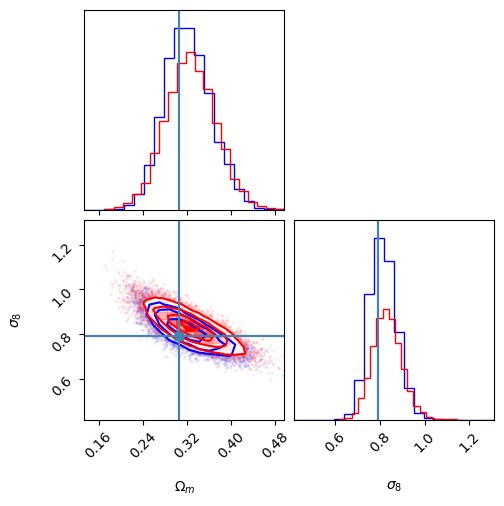

In [7]:
fig = corner.corner(np.array(posterior_samples_GNN), truths=true, labels=[r"$\Omega_m$", r"$\sigma_8$", r"$w_0$"],
                    color="blue", range=np.array([np.min(prim_labels, axis=0), np.max(prim_labels, axis=0)]).T)
fig = corner.corner(np.array(posterior_samples_prim), truths=true, labels=[r"$\Omega_m$", r"$\sigma_8$", r"$w_0$"],
                    fig=fig, color="red")

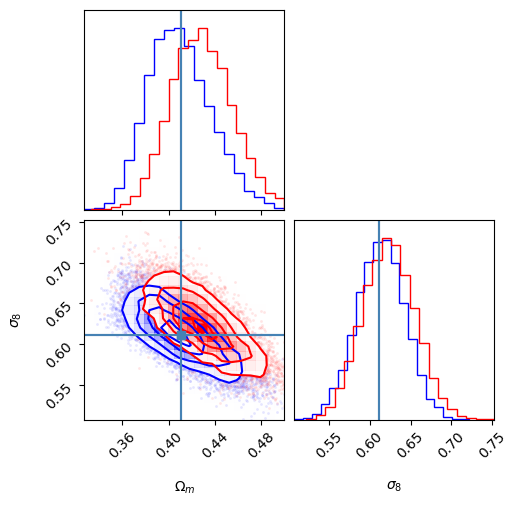

In [8]:
fig = corner.corner(np.array(posterior_samples_prim), truths=x_0, labels=[r"$\Omega_m$", r"$\sigma_8$", r"$w_0$"],
                    color="blue")
fig = corner.corner(np.array(posterior_samples_GNN), truths=x_0, labels=[r"$\Omega_m$", r"$\sigma_8$", r"$w_0$"],
                    fig=fig, color="red")

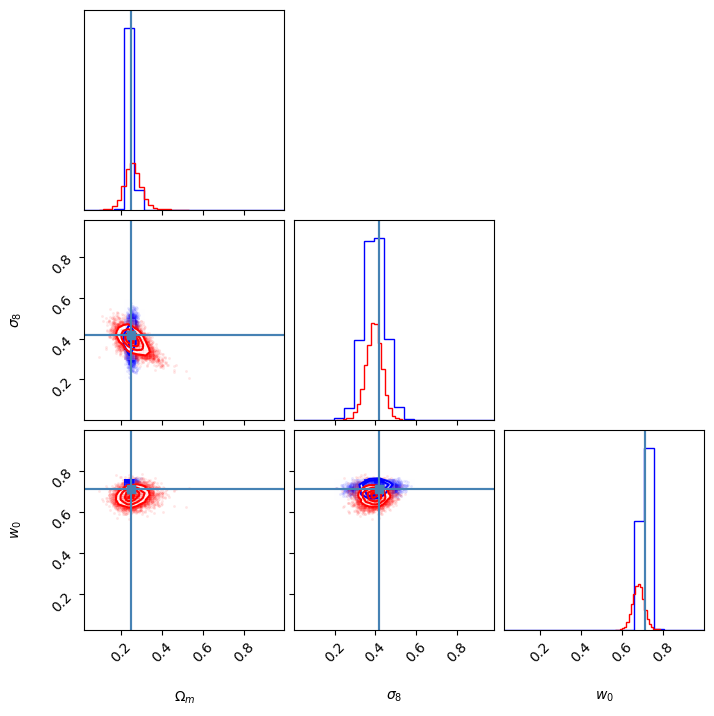

In [ ]:
fig = corner.corner(np.array(posterior_samples_vit), truths=x_0, labels=[r"$\Omega_m$", r"$\sigma_8$", r"$w_0$"],
                    color="blue", range=np.array([np.min(vit_labels, axis=0), np.max(vit_labels, axis=0)]).T)
fig = corner.corner(np.array(posterior_samples_resnet), truths=x_0, labels=[r"$\Omega_m$", r"$\sigma_8$", r"$w_0$"],
                    fig=fig, color="red")

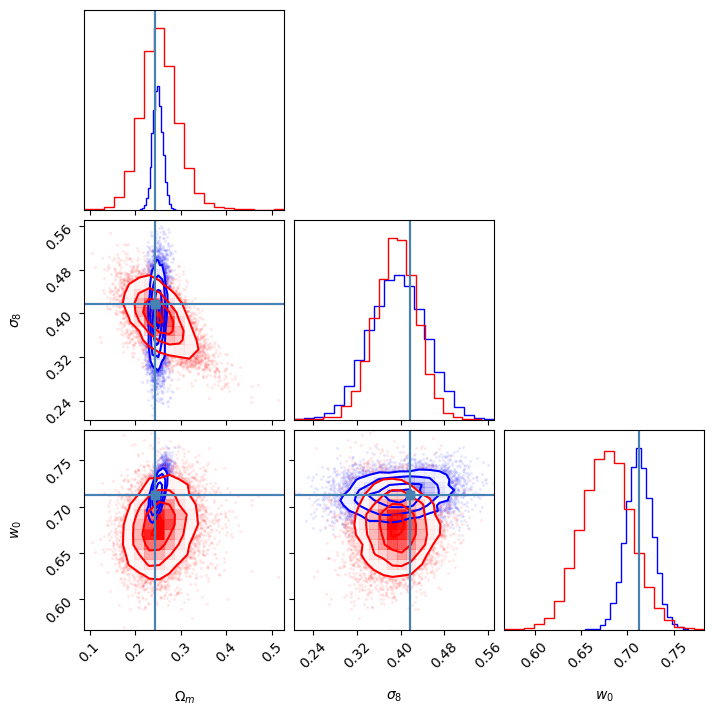

In [ ]:
fig = corner.corner(np.array(posterior_samples_vit), truths=x_0, labels=[r"$\Omega_m$", r"$\sigma_8$", r"$w_0$"],
                    color="blue")
fig = corner.corner(np.array(posterior_samples_resnet), truths=x_0, labels=[r"$\Omega_m$", r"$\sigma_8$", r"$w_0$"],
                    fig=fig, color="red")